# Imports

In [1]:
import holidays
import joblib

import pandas as pd
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skopt.plots import plot_objective

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer

## Leitura dos Dados

In [2]:
df = pd.read_csv('../data/modeling_data.csv')

df["date"] = pd.to_datetime(df["date"])

# Feature Engineering

Etapa onde crio features a partir da relação com features existentes, a fim de obter uma melhor acuracia do modelo.

Por se tratar de uma previsão de DAU, e os reportes serem em uma forma de série temporal, crio features com janelas de até 2 semanas.

Verificando o espaço entre as safras e o formato do reporte, adicionei também eventos sasonais como feriados nacionais e datas com maior potencial de uso como finais de semana.

In [3]:
df = df.sort_values(by=["appId", "date"])

def create_lagged_features(df, target_col="dauReal", n_lags=14):
    df = df.sort_values(by=["appId", "date"]).copy()
    
    for lag in range(1, n_lags + 1):
        df[f"{target_col}_d-{lag}"] = df.groupby("appId")[target_col].shift(lag)
    
    df[f"{target_col}_d"] = df[target_col]
    
    return df.dropna()

df_lagged = create_lagged_features(df)


In [4]:
def add_temporal_flags(df, date_col="date", holiday_years=[2024]):
    df = df.copy()
    
    # Finais de semana: 5 = sábado, 6 = domingo
    df["is_weekend"] = df[date_col].dt.dayofweek >= 5

    # Feriados nacionais do Brasil
    br_holidays = holidays.Brazil(years=holiday_years)
    df["is_brazilian_holiday"] = df[date_col].isin(br_holidays)

    return df

df_lagged = add_temporal_flags(df_lagged)

C:\Users\ailto\AppData\Local\Temp\ipykernel_27720\1308082482.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_brazilian_holiday"] = df[date_col].isin(br_holidays)


# Encoding

Preciso realizar o encoding da variavel categórica ***category*** para o formato numérico.

In [5]:
label_encoder = LabelEncoder()

df_lagged['category'] = label_encoder.fit_transform(df_lagged['category'])

joblib.dump(label_encoder, "../models/df_encoded.joblib")

['../models/df_encoded.joblib']

# Modelagem

In [6]:
df_lagged

,appId,date,dauReal,mauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,...,dauReal_d-8,dauReal_d-9,dauReal_d-10,dauReal_d-11,dauReal_d-12,dauReal_d-13,dauReal_d-14,dauReal_d,is_weekend,is_brazilian_holiday
14,com.app.10626,2024-04-06,251404.0,1918768.0,33062.0,4746.0,1,467243.0,426.0,120663.0,...,275086.0,287584.0,247458.0,259606.0,264645.0,206984.0,223700.0,251404.0,True,False
15,com.app.10626,2024-04-07,221422.0,1915974.0,32304.0,4122.0,1,467669.0,358.0,120723.0,...,236586.0,275086.0,287584.0,247458.0,259606.0,264645.0,206984.0,221422.0,True,False
16,com.app.10626,2024-04-08,299625.0,1912819.0,35062.0,4136.0,1,468027.0,525.0,120861.0,...,195633.0,236586.0,275086.0,287584.0,247458.0,259606.0,264645.0,299625.0,False,False
17,com.app.10626,2024-04-09,299524.0,1912253.0,35093.0,4153.0,1,468552.0,595.0,120993.0,...,298509.0,195633.0,236586.0,275086.0,287584.0,247458.0,259606.0,299524.0,False,False
18,com.app.10626,2024-04-10,330709.0,1915340.0,34576.0,4172.0,1,469147.0,496.0,121142.0,...,293935.0,298509.0,195633.0,236586.0,275086.0,287584.0,247458.0,330709.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34639,com.app.92275,2024-04-09,63495.0,585384.0,5288.0,1376.0,4,228243.0,30.0,28471.0,...,57629.0,47672.0,51109.0,53577.0,58884.0,58874.0,60300.0,63495.0,False,False
34640,com.app.92275,2024-04-10,63093.0,584652.0,5275.0,1660.0,4,228273.0,37.0,28475.0,...,62570.0,57629.0,47672.0,51109.0,53577.0,58884.0,58874.0,63093.0,False,False
34641,com.app.92275,2024-04-11,58240.0,583524.0,5223.0,1521.0,4,228310.0,34.0,28476.0,...,62488.0,62570.0,57629.0,47672.0,51109.0,53577.0,58884.0,58240.0,False,False
34642,com.app.92275,2024-04-12,54823.0,580439.0,5169.0,2962.0,4,228344.0,36.0,28481.0,...,62348.0,62488.0,62570.0,57629.0,47672.0,51109.0,53577.0,54823.0,False,False


In [7]:
df_lagged = df_lagged[
    [
        'appId','date','dauReal_d-1', 'dauReal_d-2', 'dauReal_d-3', 
        'dauReal_d-4', 'dauReal_d-5', 'dauReal_d-6', 
        'dauReal_d-7', 'dauReal_d-8', 'dauReal_d-9', 'dauReal_d-10',
        'dauReal_d-11', 'dauReal_d-12', 'dauReal_d-13', 'dauReal_d-14',
        'category', 'is_weekend', 'is_brazilian_holiday', 'dauReal_d',
        'newinstalls', 'ratings', 'daily_ratings', 'reviews', 'daily_reviews'
    ]
]

In [8]:
df_lagged.head()

,appId,date,dauReal_d-1,dauReal_d-2,dauReal_d-3,dauReal_d-4,dauReal_d-5,dauReal_d-6,dauReal_d-7,dauReal_d-8,...,dauReal_d-14,category,is_weekend,is_brazilian_holiday,dauReal_d,newinstalls,ratings,daily_ratings,reviews,daily_reviews
14,com.app.10626,2024-04-06,312332.0,272590.0,281329.0,293935.0,298509.0,195633.0,236586.0,275086.0,...,223700.0,1,True,False,251404.0,4746.0,467243.0,426.0,120663.0,60.0
15,com.app.10626,2024-04-07,251404.0,312332.0,272590.0,281329.0,293935.0,298509.0,195633.0,236586.0,...,206984.0,1,True,False,221422.0,4122.0,467669.0,358.0,120723.0,138.0
16,com.app.10626,2024-04-08,221422.0,251404.0,312332.0,272590.0,281329.0,293935.0,298509.0,195633.0,...,264645.0,1,False,False,299625.0,4136.0,468027.0,525.0,120861.0,132.0
17,com.app.10626,2024-04-09,299625.0,221422.0,251404.0,312332.0,272590.0,281329.0,293935.0,298509.0,...,259606.0,1,False,False,299524.0,4153.0,468552.0,595.0,120993.0,149.0
18,com.app.10626,2024-04-10,299524.0,299625.0,221422.0,251404.0,312332.0,272590.0,281329.0,293935.0,...,247458.0,1,False,False,330709.0,4172.0,469147.0,496.0,121142.0,134.0


## Treinando o modelo

Os modelos serão treinados com Cross Validation para prevermos as series temporais dos eventos próximos.

In [9]:
X = df_lagged[['dauReal_d-1', 'dauReal_d-2', 'dauReal_d-3', 'dauReal_d-4', 'dauReal_d-5', 'dauReal_d-6','dauReal_d-7','dauReal_d-8','dauReal_d-9','dauReal_d-10','dauReal_d-11','dauReal_d-12','dauReal_d-13','dauReal_d-14', 'category', 'is_weekend', 'is_brazilian_holiday', 'newinstalls', 'ratings', 'daily_ratings', 'reviews', 'daily_reviews']]
y = df_lagged['dauReal_d']

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

## Modelos

Inicialmente realizei um teste com 4 técnicas para chegar a um bom comparativo e entender comportamento do dado com os resultados e estabilidade futura.

**Regressão Linear**:
- Modelo simples para utilizarmos como ponto de partida.

**Random Forest**:
- Modelo baseado em bagging, onde vai prevalecer a previsão com mais votações dos modelos fracos.

**XGBoost**
- É um modelo baseado em boosting, ou seja, modelos mais fracos são treinados sequencialmente para gerar um mais forte, possui boa adapatividade em diferentes tipos de dados.

**LightBGM**
- Similar ao XGBoost, esse modelo também utiliza a técnica de boosting porém com Gradient-based One-Side Sampling e Exclusive Feature Bundling, que permitem a ela uma performance rápida e eficiente.

In [10]:
model_reports = {}

models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LGBM": LGBMRegressor(n_estimators=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

def evaluate_model(model, X, y, cv):
    mae_scores, r2_scores = [], []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mae_scores.append(mae)
        r2_scores.append(r2)

        print(f"  Fold {fold + 1}/{cv.get_n_splits()} | MAE: {mae:.2f} | R²: {r2:.2f}")

    return mae_scores, r2_scores

for name, model in models.items():
    print(f"Treinando {name}...")
    mae_scores, r2_scores = evaluate_model(model, X, y, tscv)

    metrics = {
        "Mean MAE": np.mean(mae_scores),
        "Std MAE": np.std(mae_scores),
        "Mean R²": np.mean(r2_scores),
        "Std R²": np.std(r2_scores)
    }

    model_reports[name] = metrics

    print(f"Resultados para {name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.2f}")
    print()

Treinando Linear Regression...
  Fold 1/5 | MAE: 32385.96 | R²: 0.99
  Fold 2/5 | MAE: 95308.09 | R²: 0.98
  Fold 3/5 | MAE: 27225.88 | R²: 0.95
  Fold 4/5 | MAE: 51351.98 | R²: 0.97
  Fold 5/5 | MAE: 25028.74 | R²: 1.00
Resultados para Linear Regression:
Mean MAE: 46260.13
Std MAE: 26219.06
Mean R²: 0.98
Std R²: 0.02

Treinando XGBoost...
  Fold 1/5 | MAE: 65340.23 | R²: 0.95
  Fold 2/5 | MAE: 252378.70 | R²: 0.91
  Fold 3/5 | MAE: 24531.23 | R²: 0.91
  Fold 4/5 | MAE: 71583.25 | R²: 0.96
  Fold 5/5 | MAE: 57093.25 | R²: 0.96
Resultados para XGBoost:
Mean MAE: 94185.33
Std MAE: 80741.01
Mean R²: 0.94
Std R²: 0.02

Treinando LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4852
[LightGBM] [Info] Number of data points in the train set: 5314, number of used features: 22
[LightGBM] [Info] Start training from score 480969.704178
  Fold 1/5 | 

## Tuning de Hiperparametros

Realizei alguns testes e percebi que há margem para uma melhora na etapa de tunning, como teste de faixas especificas, porém por conta do tempo, aumentei o número de iterações a fim de obter um resultado eficiente.

In [11]:
def mae_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

neg_mae = make_scorer(mae_scorer, greater_is_better=False)

param_grid = {
    "n_estimators": (50, 400),
    "max_depth": (2, 15),
    "learning_rate": (0.01, 0.3, "log-uniform"),
    "subsample": (0.5, 1.0, "uniform"),
    "colsample_bytree": (0.5, 1.0, "uniform"),
    "gamma": (0, 10), 
    "reg_alpha": (0, 1.0), 
    "reg_lambda": (0, 1.0), 

}

xgb_model = XGBRegressor(random_state=42)

bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_grid,
    scoring=neg_mae,
    cv=tscv,
    n_iter=40,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

bayes_search.fit(X, y)

print("Melhores Hiperparâmetros:", bayes_search.best_params_)
print("Melhor MAE:", -bayes_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

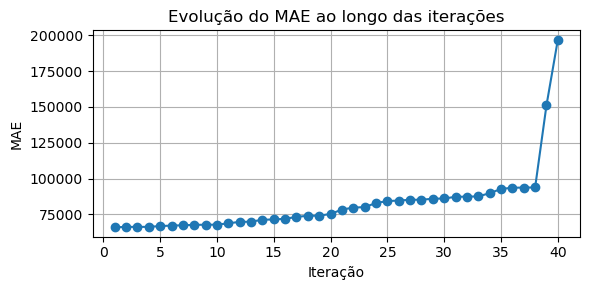

In [14]:
results_df = pd.DataFrame(bayes_search.cv_results_)

results_df = results_df.sort_values(by='rank_test_score')

scores = -results_df['mean_test_score'].values

plt.figure(figsize=(6, 3))
plt.plot(range(1, len(scores)+1), scores, marker='o')
plt.title('Evolução do MAE ao longo das iterações')
plt.xlabel('Iteração')
plt.ylabel('MAE')
plt.grid(True)
plt.tight_layout()
plt.show()

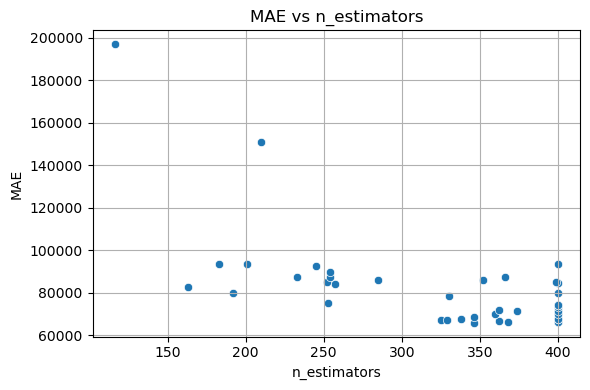

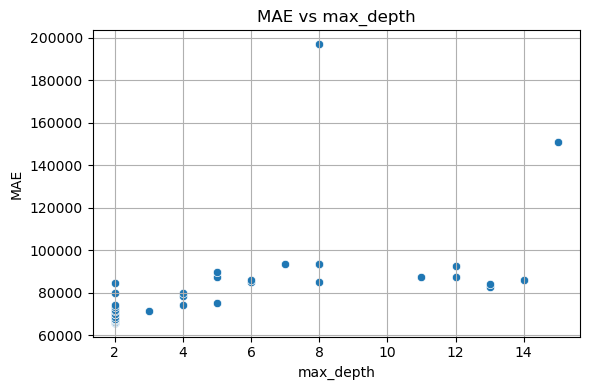

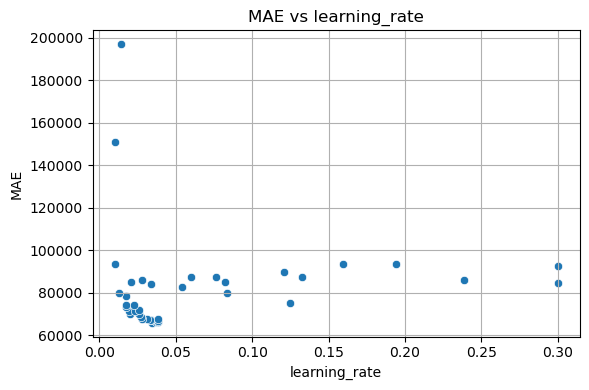

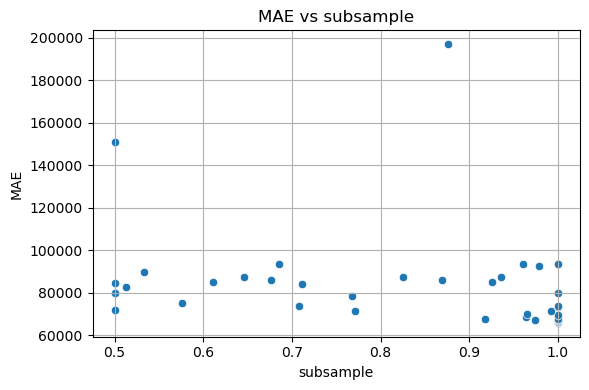

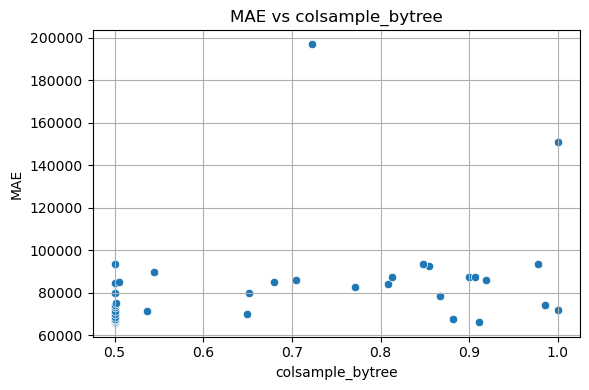

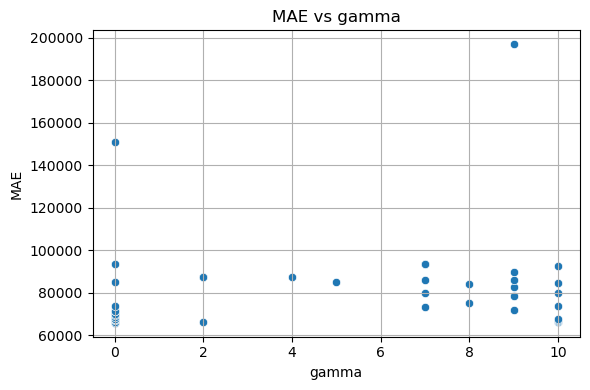

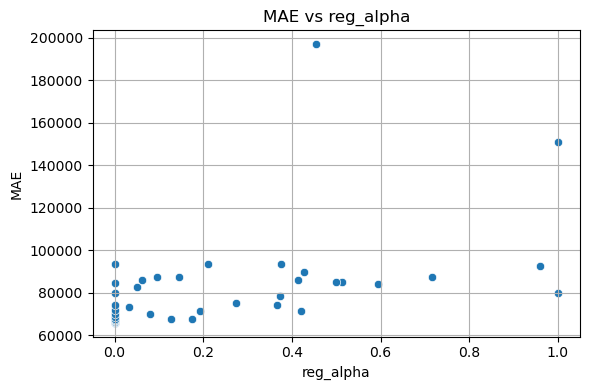

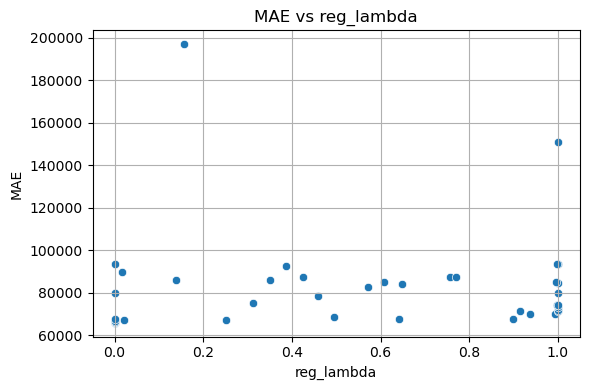

In [15]:
params = list(param_grid.keys())

for param in params:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=results_df['param_' + param], y=-results_df['mean_test_score'])
    plt.title(f"MAE vs {param}")
    plt.xlabel(param)
    plt.ylabel("MAE")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
best_params = bayes_search.best_params_

final_model = XGBRegressor(**best_params)

final_model.fit(X, y)

joblib.dump(final_model, "../models/xgb_model.joblib")

['../models/xgb_model.joblib']